# Smith Chart Coordinate Systems and Transformations

This notebook documents all the different coordinate systems and transformations used in the pysmithchart library.


In [1]:
# Standard imports and JupyterLite compatibility
%config InlineBackend.figure_format = 'retina'
import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite
    await piplite.install("pysmithchart")

from pysmithchart import SmithAxes, REFLECTANCE_DOMAIN, IMPEDANCE_DOMAIN, ABSOLUTE_DOMAIN, ADMITTANCE_DOMAIN
from pysmithchart.utils import moebius_transform, moebius_inverse_transform


## 1. Physical Parameter Domains

These represent the actual electrical parameters we're measuring or calculating.

**CRITICAL USAGE NOTE:**
- When specifying `IMPEDANCE_DOMAIN` use **absolute** impedance values in Ohms (e.g., 50+25j Ω)
- When specifying `ADMITTANCE_DOMAIN` use **absolute** admittance values in Siemens
- When specifying `ABSOLUTE_DOMAIN` use normalized impedance values (dimensionless)
- When specifying `REFLECTANCE_DOMAIN` use reflection values Γ
- The library automatically normalizes by Z₀ (default 50Ω) internally
- **Do NOT** normalize your values before plotting with IMPEDANCE_DOMAIN or ADMITTANCE_DOMAIN!

### 1.1 Impedance (Z-parameters)

**Definition:** Complex impedance Z = R + jX
- R = resistance (real part)
- X = reactance (imaginary part)
- Units: Ohms (Ω)

**Absolute vs Normalized:**
- **Absolute impedance:** Z = 50 + 25j Ω (actual physical value) ← **Plot this with IMPEDANCE_DOMAIN**
- **Normalized impedance:** z = Z/Z₀ = (50 + 25j)/50 = 1 + 0.5j (dimensionless) ← For understanding only
  - Z₀ is the characteristic impedance (typically 50Ω for RF systems)
  - The library does normalization internally, you provide absolute values

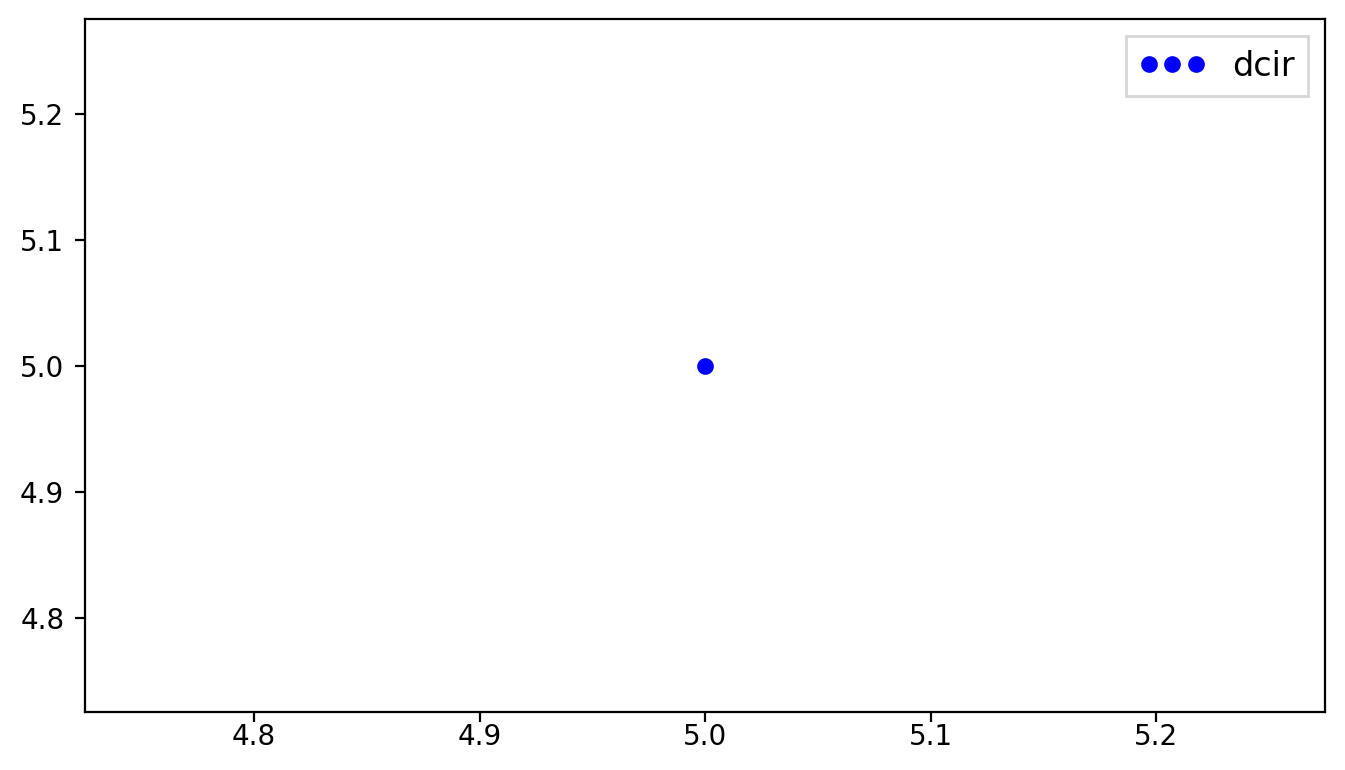

In [13]:
plt.plot(5,5,'bo',label='dcir')
plt.legend()
plt.show()

Absolute impedance: (50+25j) Ω
Normalized impedance: (1+0.5j)
Note: With IMPEDANCE_DOMAIN, plot the absolute value Z, not z_normalized!


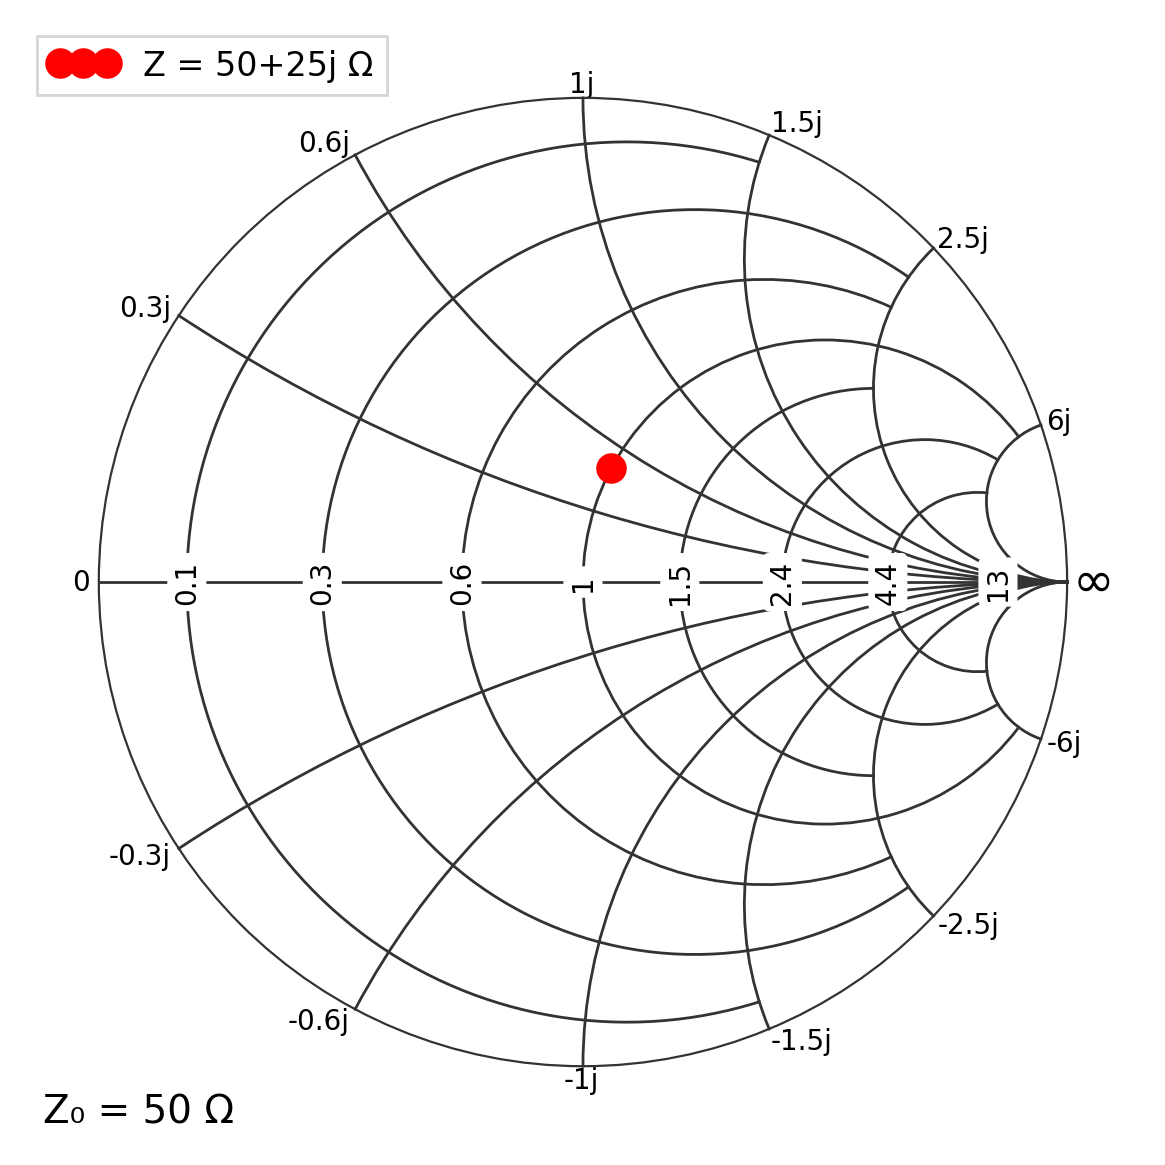

In [14]:
# Example: A load with 50Ω resistance and 25Ω inductive reactance
Z = 50 + 25j  # Ohms (absolute impedance)
Z0 = 50  # Characteristic impedance (default)
z_normalized = Z / Z0  # For reference: what gets plotted internally

print(f"Absolute impedance: {Z} Ω")
print(f"Normalized impedance: {z_normalized}")
print(f"Note: With IMPEDANCE_DOMAIN, plot the absolute value Z, not z_normalized!")

# Visualize on Smith chart - plot ABSOLUTE impedance
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)
ax.plot(Z, 'ro', markersize=10, domain=IMPEDANCE_DOMAIN, label='Z = 50+25j Ω')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 1.2 Admittance (Y-parameters)

**Definition:** Complex admittance Y = G + jB = 1/Z
- G = conductance (real part)
- B = susceptance (imaginary part)
- Units: Siemens (S)

**Relationship:** Y = 1/Z and Z = 1/Y

**Important:** Since Y = 1/Z, plotting Y with ADMITTANCE_DOMAIN should show the point at the **same location** as plotting Z with IMPEDANCE_DOMAIN. The library converts Y to Z internally, then normalizes.

Impedance Z: (50+25j) Ω
Admittance Y: (0.016-0.008j) S
Verify Z = 1/Y: (50+25j)

Note: Z and Y should plot at the SAME location!
Both represent the same physical component.


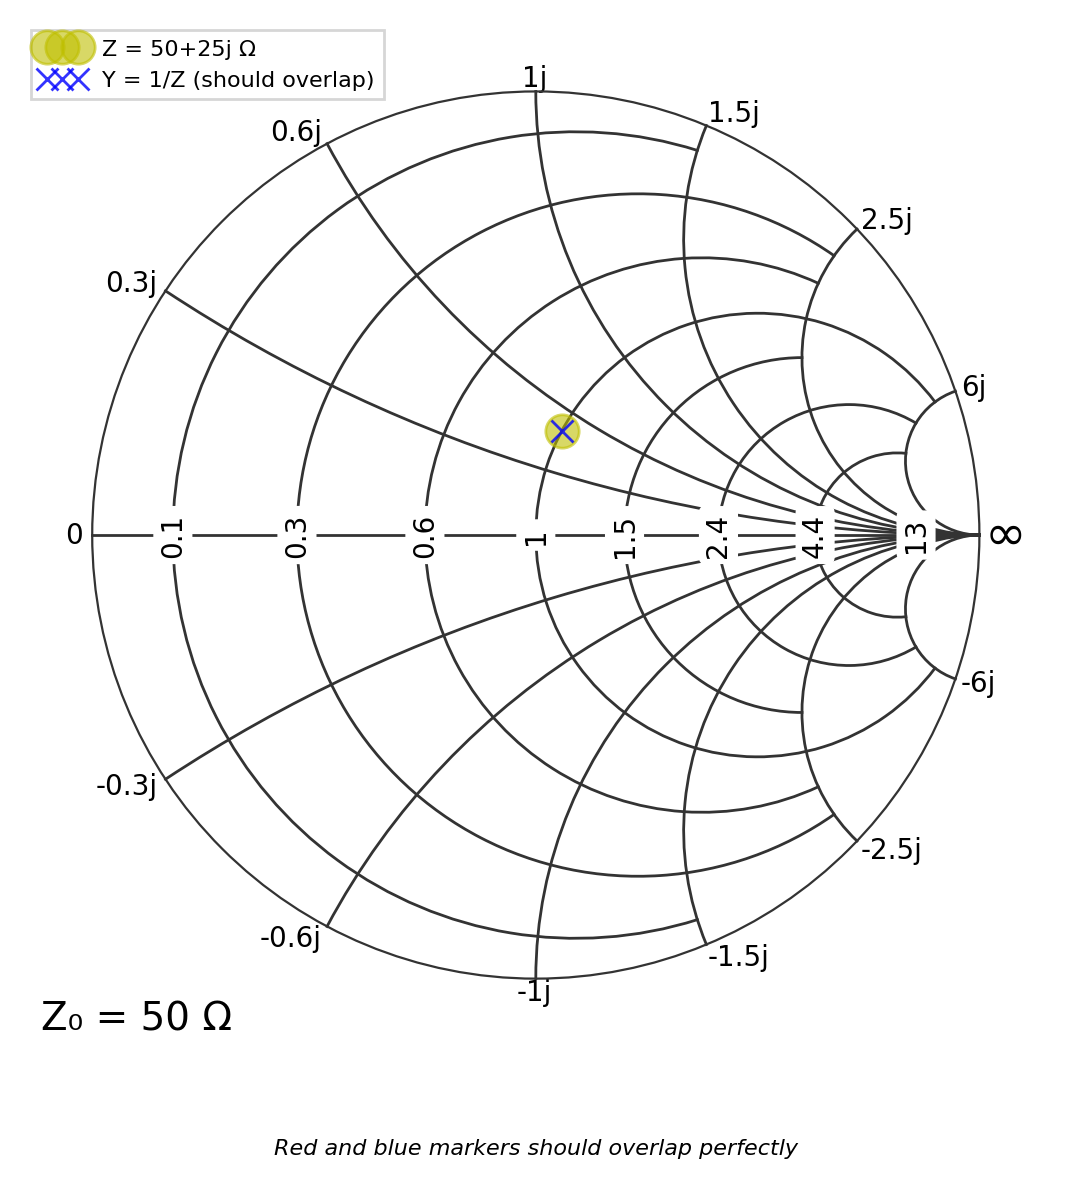

In [3]:
# The admittance of the above impedance
Z = 50 + 25j  # Absolute impedance in Ohms
Y = 1/Z  # Absolute admittance in Siemens

print(f"Impedance Z: {Z} Ω")
print(f"Admittance Y: {Y} S")
print(f"Verify Z = 1/Y: {1/Y}")
print(f"\nNote: Z and Y should plot at the SAME location!")
print(f"Both represent the same physical component.")

# Visualize both on Smith chart - they should overlap!
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)
ax.plot(Z, 'yo', markersize=12, domain=IMPEDANCE_DOMAIN, label='Z = 50+25j Ω', alpha=0.6)
ax.plot(Y, 'bx', markersize=8, domain=ADMITTANCE_DOMAIN, label='Y = 1/Z (should overlap)', alpha=0.8)
ax.legend(loc='upper left', fontsize=8)
ax.text(0.5, -0.1, 'Red and blue markers should overlap perfectly', 
        transform=ax.transAxes, ha='center', fontsize=8, style='italic')
plt.tight_layout()
plt.show()

### 1.3 Scattering Parameters (S-parameters)

**Definition:** Reflection coefficient Γ (gamma)
- Represents the ratio of reflected wave to incident wave
- Complex number: Γ = |Γ|∠θ
- Dimensionless
- For passive devices: |Γ| ≤ 1 (inside unit circle)

**Why "Scattering" AND "Reflection"?**

The terms are related but refer to different aspects of the same phenomenon:

**Scattering Parameters (S-parameters)** is the general framework that describes how RF/microwave signals scatter when they encounter a network or device. For a 2-port device, there are four S-parameters:
- S₁₁: Input reflection coefficient (what we plot on the Smith chart)
- S₂₁: Forward transmission coefficient
- S₁₂: Reverse transmission coefficient  
- S₂₂: Output reflection coefficient

**Reflection Coefficient** specifically refers to S₁₁ (or S₂₂), which measures the signal reflected back from a single port. This is what we visualize on the Smith chart.

So "scattering parameters" is the complete mathematical framework, while "reflection coefficient" is the specific parameter we're plotting. Think of it like "temperature measurements" (general framework) versus "current temperature" (specific value). In practice, when people say "plot the S-parameters on a Smith chart," they specifically mean the reflection coefficients (S₁₁ or S₂₂), not the transmission coefficients.

**Physical meaning:**
- S = 0: Perfect match (no reflection)
- |S| = 1: Total reflection
- S = 1: Short circuit
- S = -1: Open circuit

**Usage in pysmithchart:**

When you specify `domain=REFLECTANCE_DOMAIN`, you're providing S-parameter (reflection coefficient) values that will be automatically converted to the appropriate impedance coordinates for display on the Smith chart. The library handles the transformation internally.

S-parameter: (0.5+0.3j)
Magnitude |S|: 0.583 (58.3% voltage reflection)
Phase angle: 31.0°


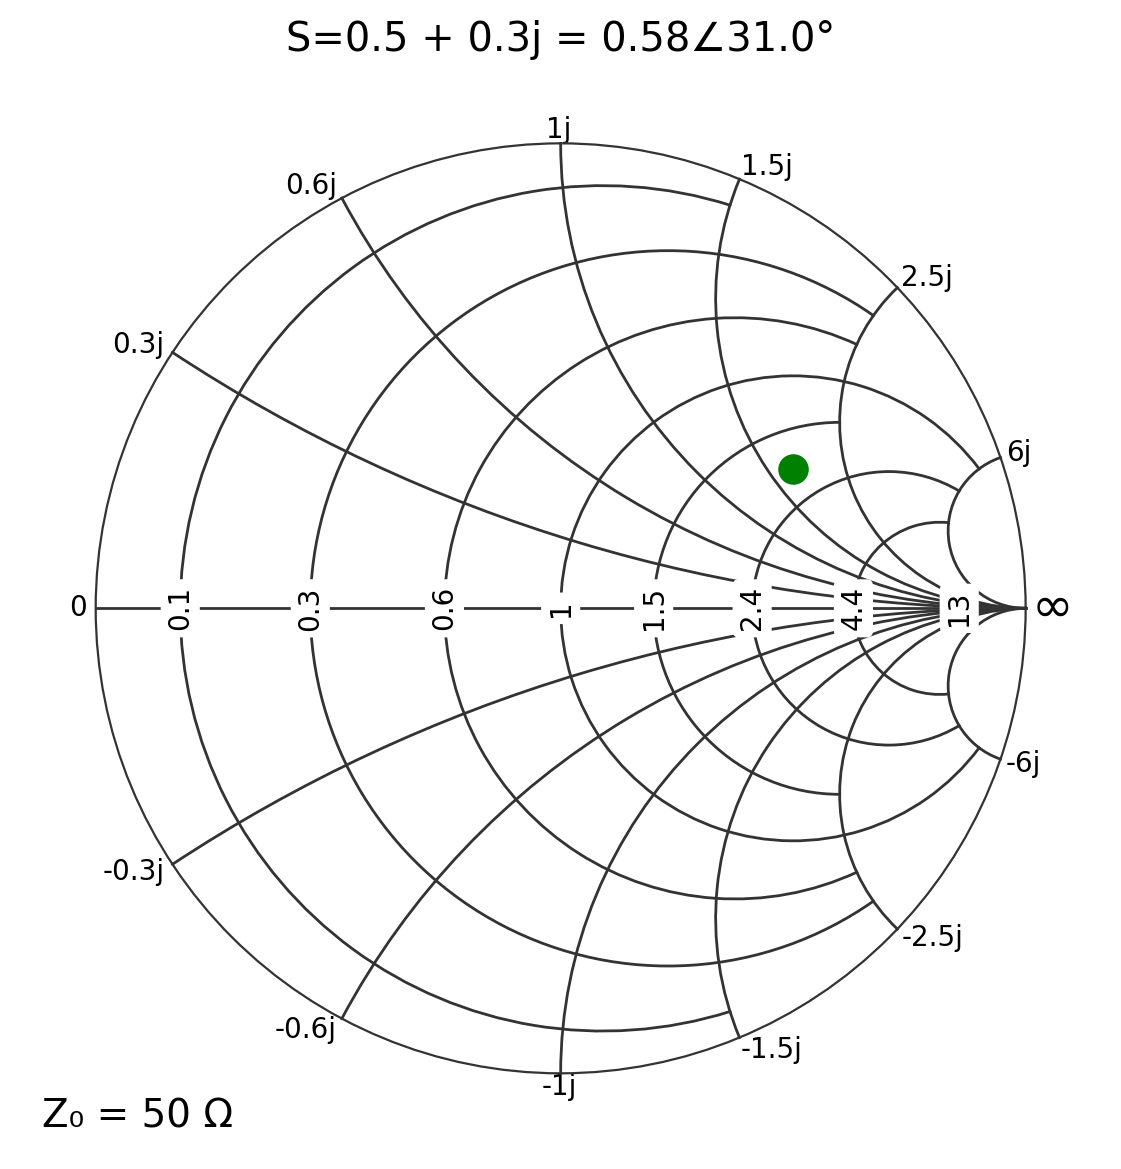

In [4]:
S = 0.5 + 0.3j
magnitude = abs(S)
angle_deg = np.angle(S, deg=True)

print(f"S-parameter: {S}")
print(f"Magnitude |S|: {magnitude:.3f} ({magnitude*100:.1f}% voltage reflection)")
print(f"Phase angle: {angle_deg:.1f}°")

# Plot S-parameter directly
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)
ax.plot([S.real], [S.imag], 'go', markersize=10, domain=REFLECTANCE_DOMAIN, label=f'S = {S:.2f}')
#ax.legend(loc='upper left', fontsize=8)
ax.set_title('S=%.1f + %.1fj = %.2f∠%.1f°' % (S.real, S.imag, magnitude, angle_deg))
plt.tight_layout()
plt.show()

### 1.4 Arbitrary Parameters (A-parameters)

**Definition:** ABSOLUTE_DOMAIN allows you to work directly in the Smith chart's display coordinate system without worrying about Z0.  This allows one to plot normalized z values directly.

**When to use ABSOLUTE_DOMAIN:**
- When you want to plot points directly at specific coordinates on the Smith chart
- When you already have data in the transformed (reflection coefficient display) domain
- When you want to draw custom shapes or annotations at exact display positions
- For advanced applications where you're working directly with the chart geometry

**Key difference:**
- `IMPEDANCE_DOMAIN`: Input represents impedance → normalized →  transformed via Möbius to display position
- `REFLECTANCE_DOMAIN`: Input represents reflection coefficient → gets transformed via inverse Möbius to impedance → then Möbius to display position
- `ABSOLUTE_DOMAIN`: Input goes directly to display position

**Example use case:** Weirdly, circles remain circles under a Mobius transform.  So it is easy to draw a circle.  The problem is the center is not quite where it should be.  You can see in the graph below that the radius is 0.3 along constant resistance lines as well as 0.3 along constant reactance lines.

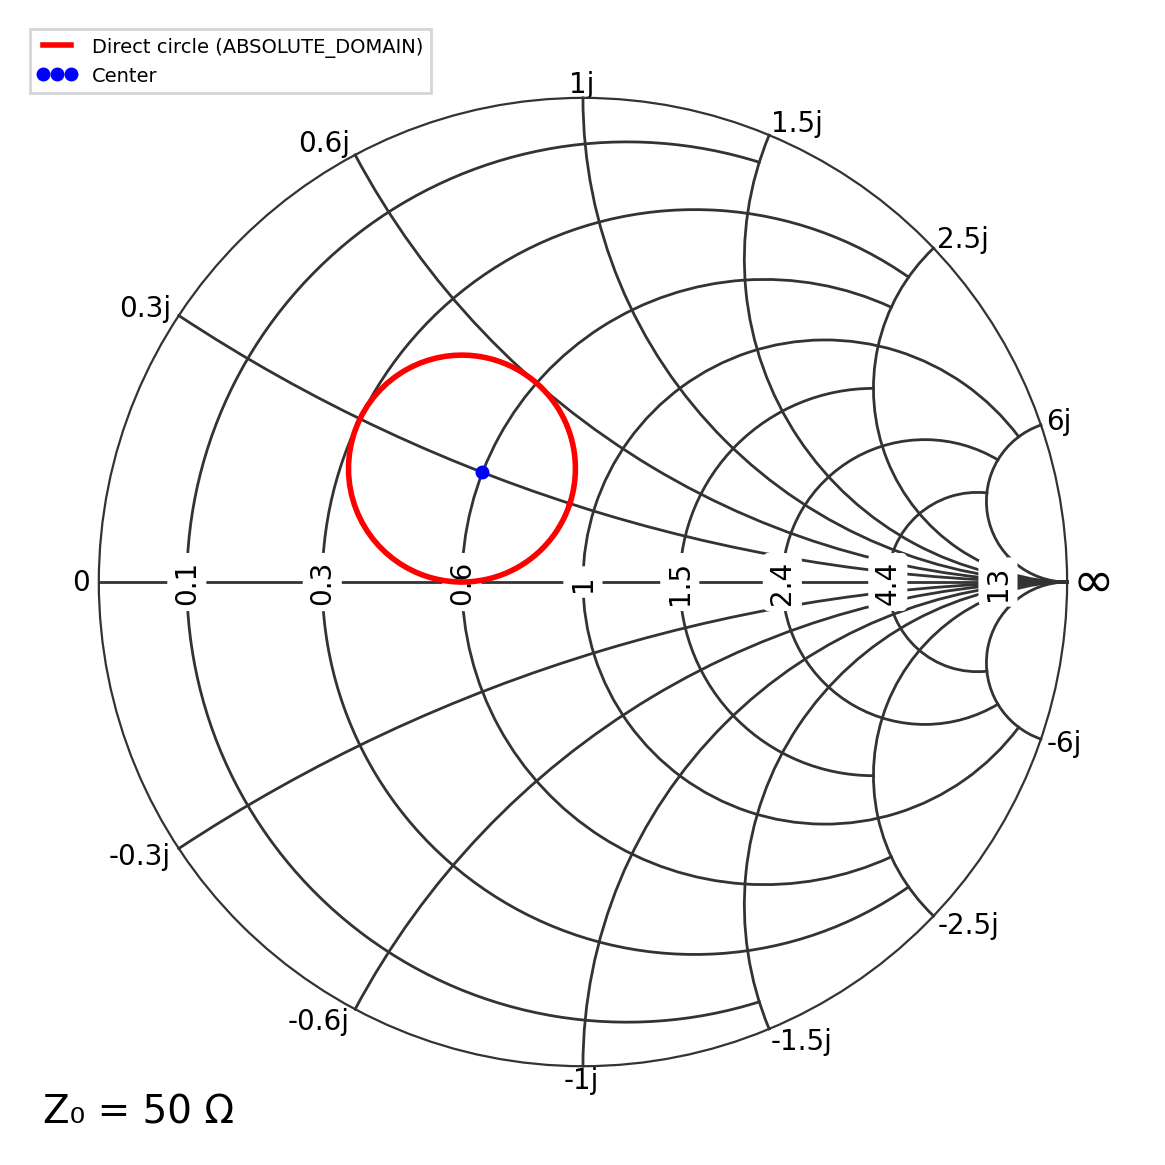

In [5]:
# Example: Plot a circle in the display domain

theta = np.linspace(0, 2*np.pi, 100)
radius = 0.3
z_center = 0.6 + 0.3j
z_circle = z_center + radius * np.exp(1j * theta)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)

# Plot circle become circles using ABSOLUTE_DOMAIN (no transformation)
ax.plot(z_circle, 'r-', linewidth=2, domain=ABSOLUTE_DOMAIN, label='Direct circle (ABSOLUTE_DOMAIN)')

# Plot the center which is not preserved
ax.plot(z_center, 'b.', markersize=8, domain=ABSOLUTE_DOMAIN, label='Center')

ax.legend(loc='upper left', fontsize=7)
plt.tight_layout()
plt.show()

---

## 2. Möbius Transform

The Möbius transformation is the mathematical mapping between impedance and S-parameters.

### 2.1 Forward Transform: Impedance → S-parameter

**Formula (normalized):**
```
S = (z - 1)/(z + 1)

OR equivalently:

S = 1 - 2/(z + 1)
```

Where z = Z/Z₀ is normalized impedance.

We'll use the transforms from pysmithchart's transform module:

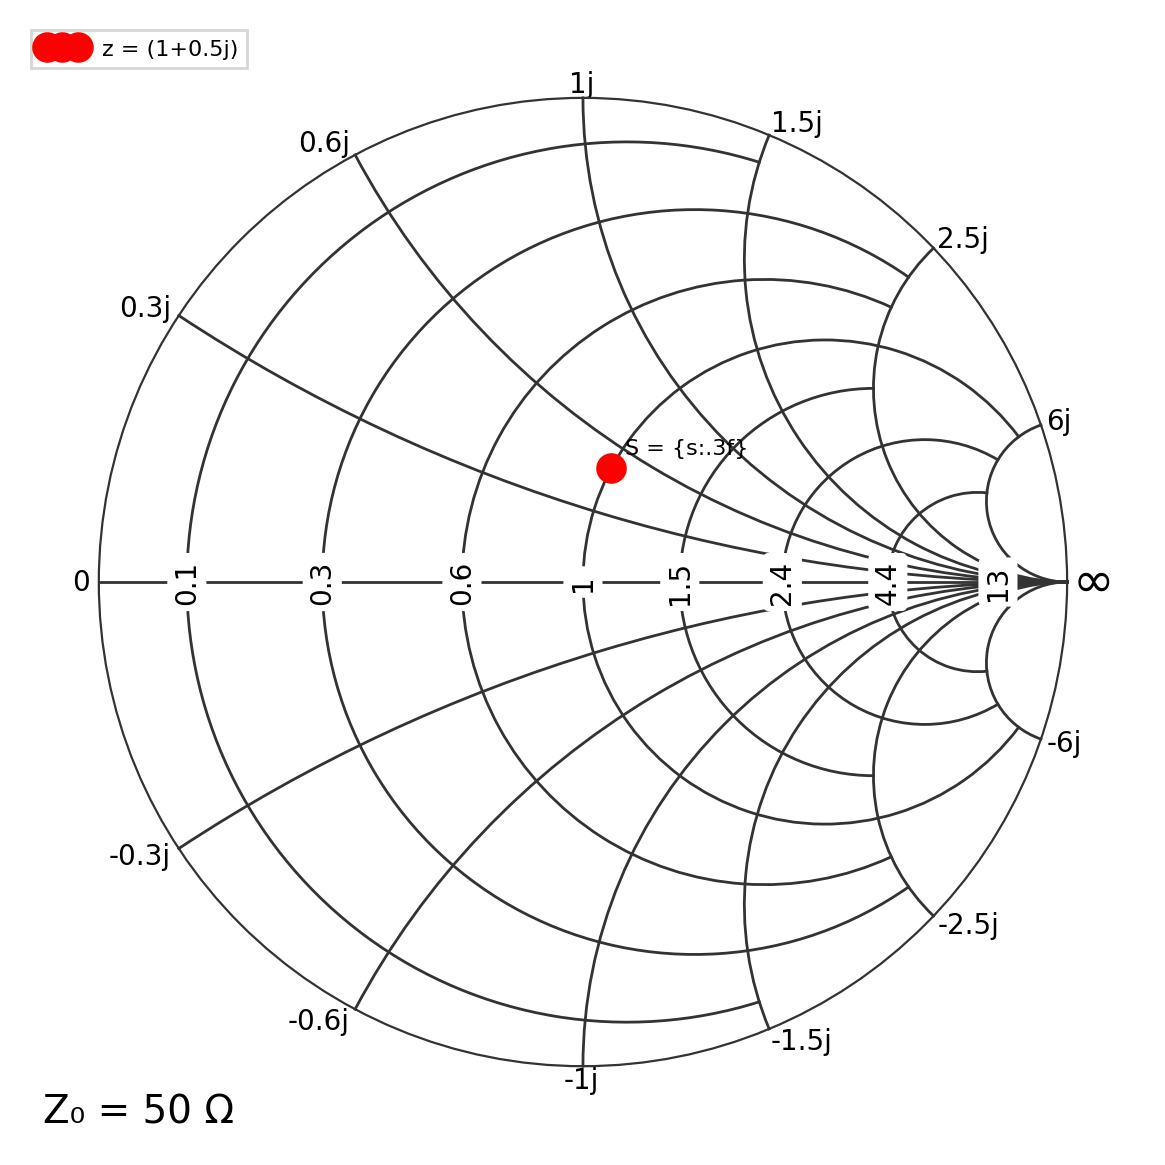

Normalized impedance z = (1+0.5j)
S-parameter S = (0.05882352941176472+0.23529411764705882j)
S magnitude: 0.243


In [6]:
# Example: z = 1 + 0.5j (normalized)
z = 1 + 0.5j

# Visualize the transformation
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)

s = ax.moebius_z(z)
ax.plot(z, 'ro', markersize=10, domain=ABSOLUTE_DOMAIN, label=f'z = {z}')
ax.annotate('S = {s:.3f}', 
            xy=(z.real, z.imag), xytext=(5, 5),
            textcoords='offset points', fontsize=8,
            domain=ABSOLUTE_DOMAIN)
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

print(f"Normalized impedance z = {z}")
print(f"S-parameter S = {s}")
print(f"S magnitude: {abs(s):.3f}")



### 2.2 Inverse Transform: S-parameter → Impedance

**Formula (normalized):**
```
z = (1 + S)/(1 - S)
```

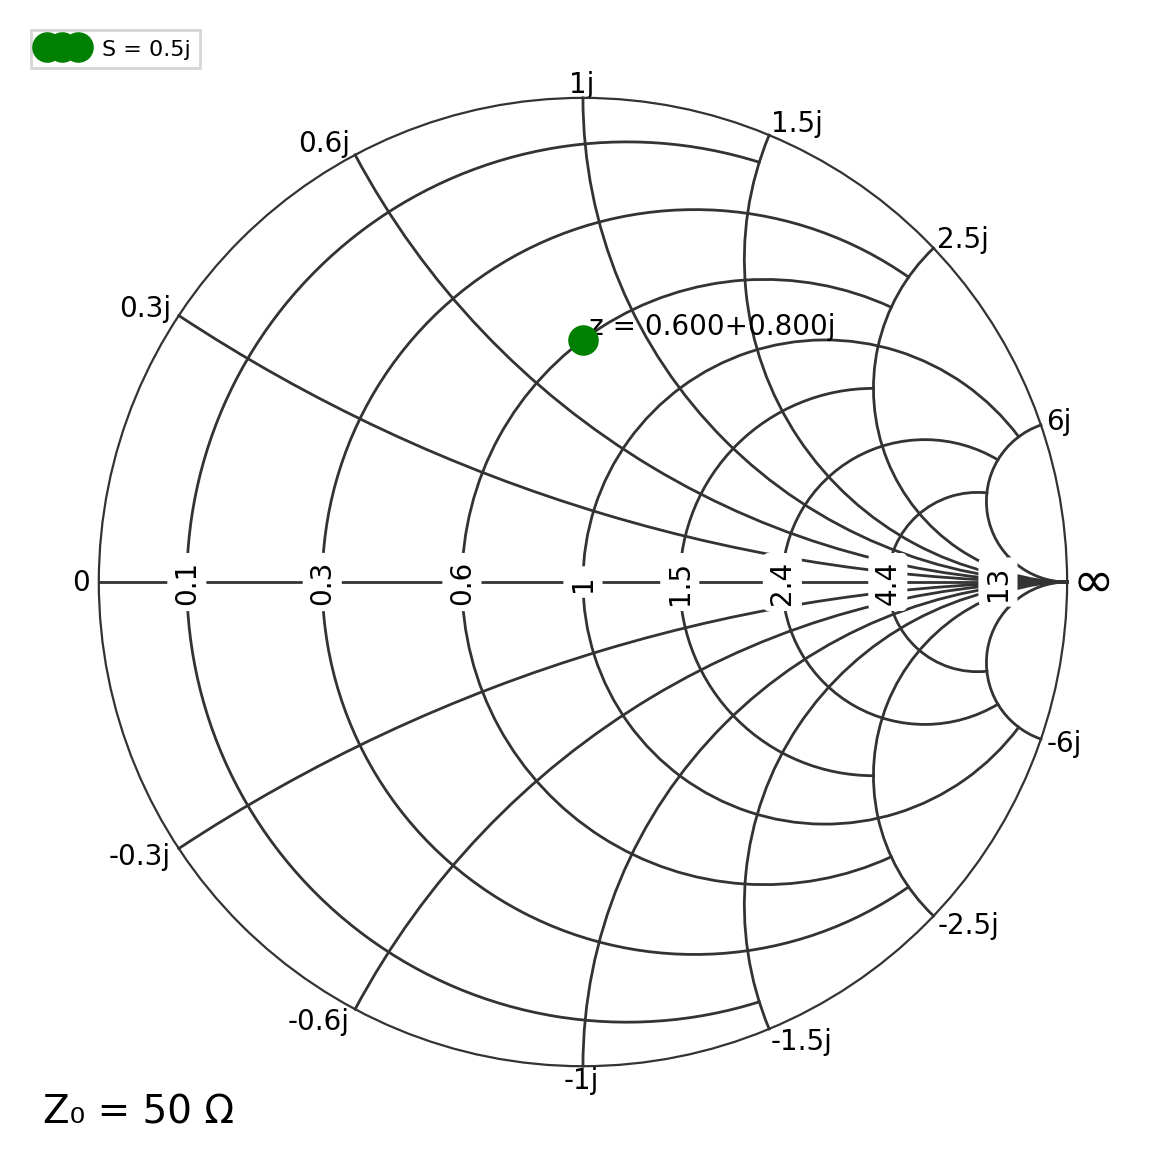

S-parameter S = 0.5j
Normalized impedance z = (0.6+0.8j)
  Resistance R/Z0 = 0.600
  Reactance  X/Z0 = 0.800


In [7]:
# Example: S = 0.5j
s = 0 + 0.5j

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)
z = ax.moebius_inv_z(s)

ax.plot([s.real], [s.imag], 'go', markersize=10, 
        domain=REFLECTANCE_DOMAIN, label=f'S = {s}')
ax.annotate(f'z = {z:.3f}', 
            xy=(s.real, s.imag), xytext=(2, 2),
            textcoords='offset points', fontsize=10,
            domain=REFLECTANCE_DOMAIN)
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

print(f"S-parameter S = {s}")
print(f"Normalized impedance z = {z}")
print(f"  Resistance R/Z0 = {z.real:.3f}")
print(f"  Reactance  X/Z0 = {z.imag:.3f}")


### 2.3 Key Properties of Möbius Transform

- Maps the unit circle |S| = 1 to the imaginary axis (R = 0)
- Maps S = 0 (center) to z = 1 (matched impedance)
- Maps S = 1 to z = ∞ (short circuit)
- Maps S = -1 to z = 0 (open circuit)

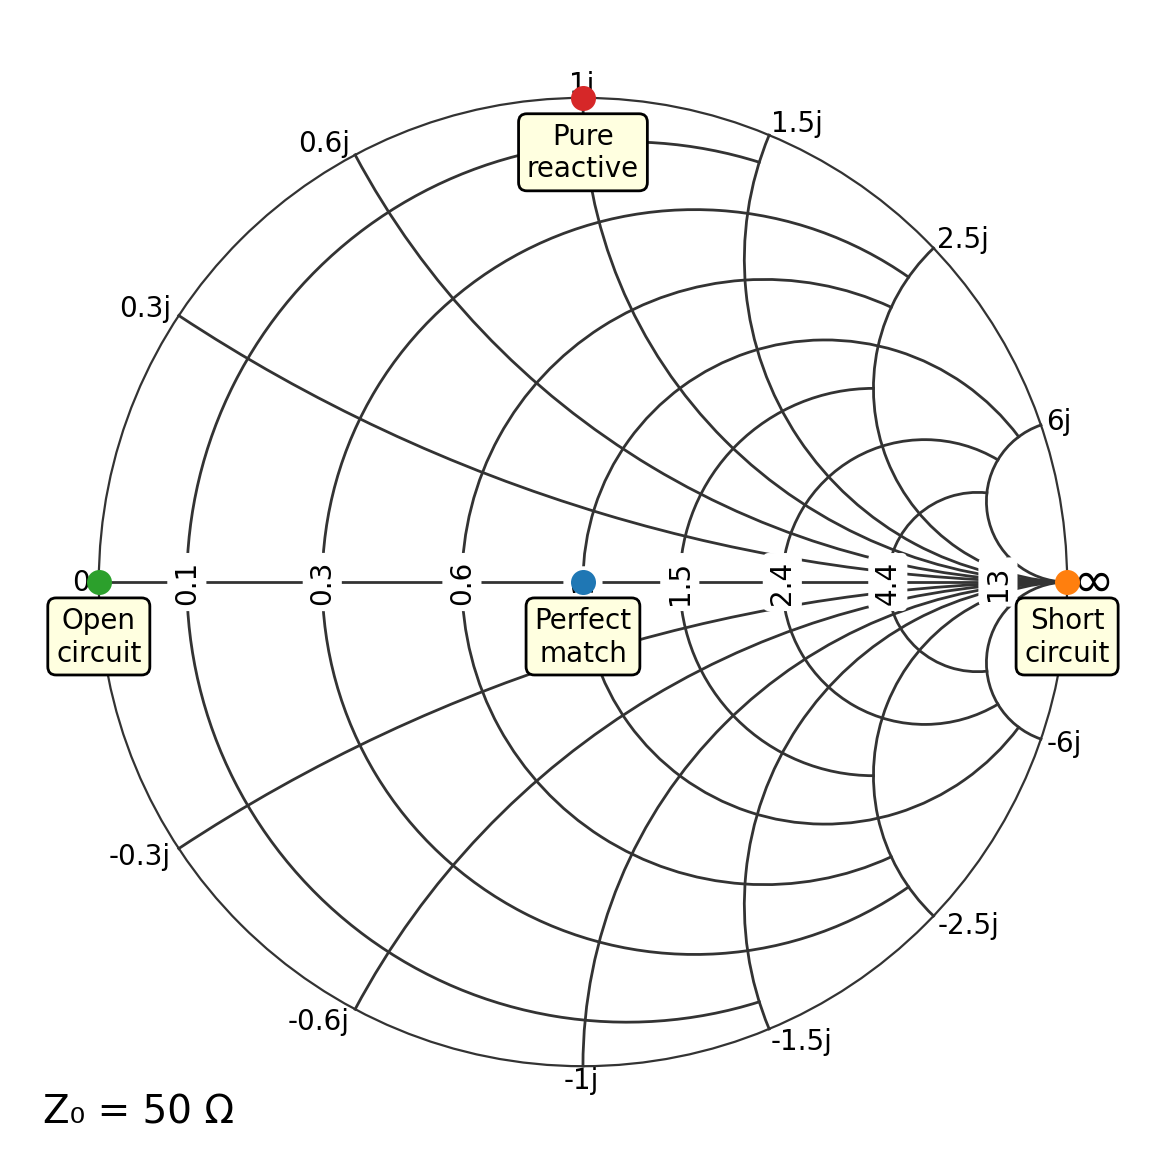

In [27]:
# Verify key mappings
test_cases = [
    (0 + 0j, "Perfect\nmatch"),
    (1 + 0j, "Short\ncircuit"),
    (-1 + 0j, "Open\ncircuit"),
    (0 + 1j, "Pure\nreactive"),
]

bdict=dict(boxstyle='round', facecolor='lightyellow', alpha=1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)

for s_test, description in test_cases:
    ax.plot(s_test, 'o', markersize=8, domain=REFLECTANCE_DOMAIN)
    ax.text(s_test-0.05j, description, fontsize=10, domain=REFLECTANCE_DOMAIN, ha='center', va='top', bbox=bdict)

plt.tight_layout()
plt.show()

### 2.4 Round-Trip Test

The forward and inverse transforms should be perfect inverses of each other.

In [28]:
# Test round-trip: z → S → z
z_original = 1 + 0.5j
s_intermediate = moebius_transform(z_original)
z_recovered = moebius_inverse_transform(s_intermediate)

print(f"Original z: {z_original}")
print(f"After forward transform S: {s_intermediate}")
print(f"After inverse transform z: {z_recovered}")
print(f"Match: {np.allclose(z_original, z_recovered)}")

# Test multiple points
test_impedances = [0.5+0.2j, 1+1j, 2-0.5j, 0.3+1.5j]
print("\nRound-trip test for multiple impedances:")
for z_test in test_impedances:
    s_test = moebius_transform(z_test)
    z_back = moebius_inverse_transform(s_test)
    match = np.allclose(z_test, z_back)
    print(f"  z={z_test} → S={s_test:.3f} → z={z_back:.3f} [Match: {match}]")

Original z: (1+0.5j)
After forward transform S: (0.05882352941176472+0.23529411764705882j)
After inverse transform z: (1+0.5j)
Match: True

Round-trip test for multiple impedances:
  z=(0.5+0.2j) → S=-0.310+0.175j → z=0.500+0.200j [Match: True]
  z=(1+1j) → S=0.200+0.400j → z=1.000+1.000j [Match: True]
  z=(2-0.5j) → S=0.351-0.108j → z=2.000-0.500j [Match: True]
  z=(0.3+1.5j) → S=0.340+0.761j → z=0.300+1.500j [Match: True]


---

## 3. Display Domain vs Impedance Domain

The Smith chart visualization involves two distinct coordinate domains that are related by the Möbius transformation.

### 3.1 Impedance Domain (What You Provide)

When you plot with `IMPEDANCE_DOMAIN`, you provide impedance values:
```python
Z = 50 + 25j  # Absolute impedance in Ohms
ax.plot(Z, 'ro', domain=IMPEDANCE_DOMAIN)
```

Internally, this gets normalized to:
```python
z = Z / Z₀ = (50 + 25j) / 50 = 1 + 0.5j  # Normalized impedance
```

### 3.2 Reflection Coefficient Domain (Display Domain)

The normalized impedance is transformed to the display domain using the Möbius transformation:
```python
# Möbius transformation: z → S
S = (z - 1) / (z + 1)  # Converts impedance to reflection coefficient
```

This is the domain where the Smith chart is actually drawn. The "data coordinates" in matplotlib are the real and imaginary parts of S (the reflection coefficient), not z.

### 3.3 Understanding the Coordinate Systems
```python
import numpy as np
import matplotlib.pyplot as plt
from pysmithchart import IMPEDANCE_DOMAIN

# Define an impedance
Z = 30 + 40j  # Absolute impedance
Z0 = 50       # Characteristic impedance

# Step 1: Normalize
z = Z / Z0  # z = 0.6 + 0.8j (normalized impedance)

# Step 2: Transform to display domain (Möbius transformation)
S = (z - 1) / (z + 1)  # S ≈ -0.231 + 0.538j (reflection coefficient)

# When you plot with IMPEDANCE_DOMAIN, the library does steps 1 and 2 automatically
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith')

# This plots at the transformed location (S domain)
ax.plot(Z, 'ro', markersize=10, domain=IMPEDANCE_DOMAIN, label=f'Z = {Z} Ω')

# The actual matplotlib coordinates are the S values (after transformation)
# NOT the z values (impedance)
ax.legend(loc='upper left')
plt.show()

print(f"Impedance (absolute):      Z = {Z} Ω")
print(f"Impedance (normalized):    z = {z}")
print(f"Reflection coefficient:    S = {S:.3f}")
print(f"Display coordinates:       ({S.real:.3f}, {S.imag:.3f})")
```

### 3.4 The Key Point: Curved Axes

**Important:** The Smith chart's axes (constant resistance circles and constant reactance arcs) are **curved**, not straight lines. This is because:

1. The display domain uses the **reflection coefficient** (S-parameters)
2. Constant impedance values map to **circles and arcs** in this domain
3. The transformation is **non-linear** (Möbius transformation)

There is no simple "x = resistance, y = reactance" mapping in the display. The gridlines you see are the result of:
- Constant resistance circles: Points where Re(z) is constant
- Constant reactance arcs: Points where Im(z) is constant

Both of these become **curved shapes** when transformed to the S-parameter display domain.

### 3.5 Why This Matters

When using `ABSOLUTE_DOMAIN`, you're providing coordinates directly in the S-parameter domain (after transformation), which is why circles don't have their centers where you'd expect - the geometry is non-Euclidean.

For normal usage with `IMPEDANCE_DOMAIN`, you don't need to worry about this - just provide impedance values and let the library handle the transformation!

## 3. Display Coordinates (Matplotlib Domain)

The Smith chart is rendered in matplotlib using 2D Cartesian coordinates.

### 3.1 Data Coordinates

**Convention in pysmithchart:** The data coordinates represent **normalized impedance domain**:
```
x-coordinate = Real(z) = R/Z₀
y-coordinate = Imag(z) = X/Z₀
```

Impedance z = (0.6+0.8j)
Matplotlib data coordinates: (0.6, 0.8)


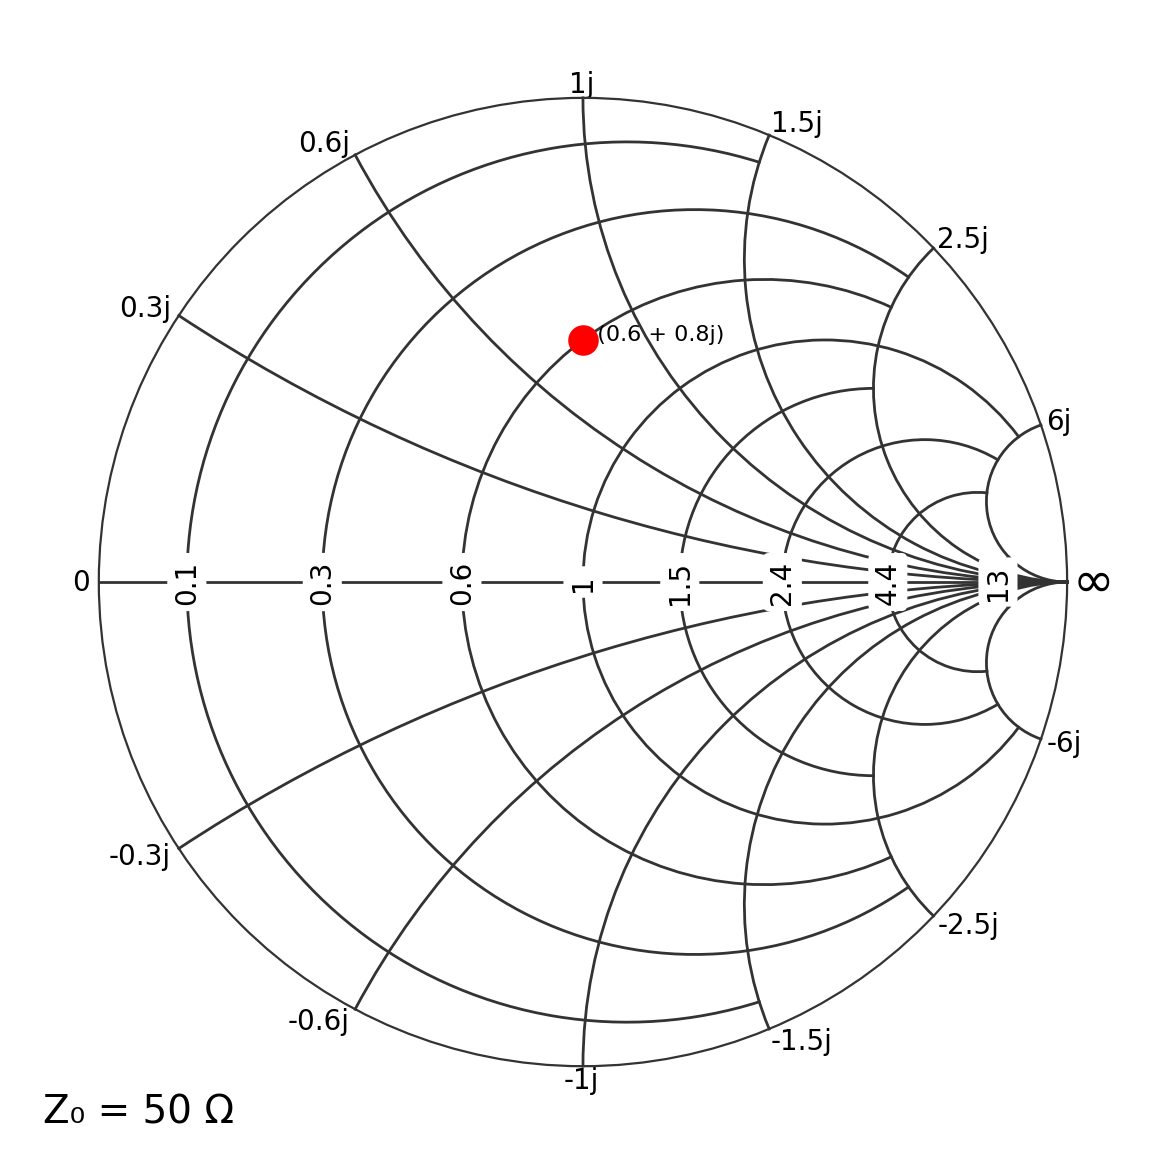

In [32]:
# Example: normalized impedance z = 0.6 + 0.8j
# is plotted at matplotlib data coordinates:
z = 0.6 + 0.8j

print(f"Impedance z = {z}")
print(f"Matplotlib data coordinates: ({x_data}, {y_data})")

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)
ax.plot(z, 'ro', markersize=10, domain=ABSOLUTE_DOMAIN)
plt.tight_layout()
plt.show()

### 3.2 Transform Pipeline

Matplotlib applies a series of transforms:

```
Data Coords → Non-Affine Transform → Affine Transform → Display Coords
   (z)             (Möbius)          (scale/translate)    (pixels)
```

**For Smith charts:**
1. **Data domain:** Normalized impedance (z = R/Z₀ + jX/Z₀)
2. **Non-affine transform (MoebiusTransform):** Maps impedance to S-parameter domain
3. **Affine transform (transMoebius):** Scales and centers the unit circle for display
4. **Display domain:** Pixel coordinates on screen

**Parameter type handling:**
- **IMPEDANCE_DOMAIN:** Data goes directly into the pipeline (impedance domain)
- **ADMITTANCE_DOMAIN:** Data is converted to impedance (z = 1/y), then enters pipeline
- **REFLECTANCE_DOMAIN:** Data is converted to impedance (z = moebius_inv_z(s)), then enters pipeline
- **ABSOLUTE_DOMAIN:** Data bypasses non-affine transform, goes directly to display

---

## 4. Grid Domain

The Smith chart grid shows constant resistance circles and constant reactance arcs.

### 4.1 Grid Lines

**Constant Resistance Circles:**
- Vertical lines in impedance domain (constant R, varying X)
- Example: R = 0.5 means all points with Real(z) = 0.5

**Constant Reactance Arcs:**
- Horizontal lines in impedance domain (constant X, varying R)
- Example: X = 0.3 means all points with Imag(z) = 0.3

In [39]:
help(ax.plot_constant_reactance)

Help on method plot_constant_reactance in module pysmithchart.plotting:

plot_constant_reactance(reactance, *args, resistance_range=None, normalized=False, num_points=200, **kwargs) method of pysmithchart.axes.SmithAxes instance
    Plot a constant reactance arc on the Smith chart.

    Args:
        reactance (float): The reactance value to plot. If normalized=False, this is
            in Ohms. If normalized=True, this is the normalized reactance (x = X/Z₀).
            Positive for inductive, negative for capacitive.
        *args: Optional format string (e.g., 'r-', 'b--', 'go').
        resistance_range (tuple, optional): The (min, max) resistance range to plot.
            If None, automatically determines range to show the full arc.
            If normalized=False, range is in Ohms. If normalized=True, range is normalized.
        normalized (bool, optional): If True, reactance and resistance_range are treated
            as normalized values. If False (default), they are in Ohm

Plotting constant reactance line X = 0.5
First few points:
  z = 0.100+0.500j
  z = 0.129+0.500j
  z = 0.159+0.500j
  z = 0.188+0.500j
  z = 0.217+0.500j


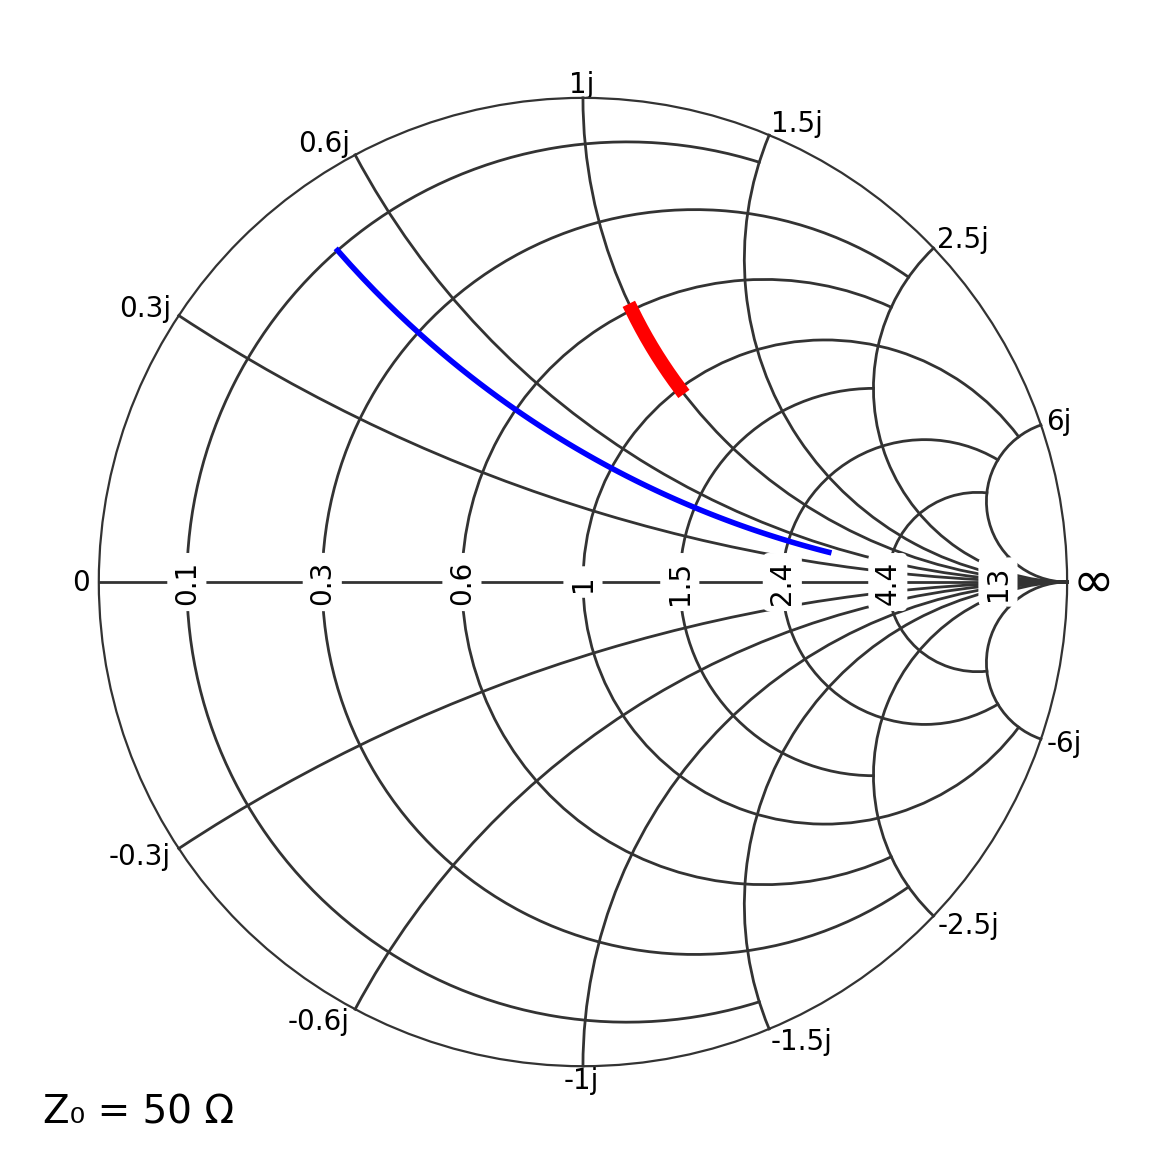


When transformed to S-parameter domain, this becomes an arc.


In [48]:
# Example: Generate points on a constant reactance line X = 0.5
# This is a horizontal line in impedance domain

X_constant = 0.5
R_values = np.linspace(0.1, 3, 100)  # Resistance from 0.1 to 3

# In impedance domain, this is just a horizontal line
z_line = R_values + 1j * X_constant

print(f"Plotting constant reactance line X = {X_constant}")
print(f"First few points:")
for i in range(0, 5):
    print(f"  z = {z_line[i]:.3f}")

# Plot the line
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith')
ax.plot(z_line, 'b', linewidth=2, domain=ABSOLUTE_DOMAIN, label=f'X = {X_constant}')
ax.plot_constant_reactance(50, "r", resistance_range=(30,50), lw=5)
plt.tight_layout()
plt.show()

print("\nWhen transformed to S-parameter domain, this becomes an arc.")

## 5. Complete Example: Plotting a Point

Let's trace what happens when we plot S = 0.5j with `domain=REFLECTANCE_DOMAIN`

In [12]:
# Step 1: Input
s_input = 0 + 0.5j
print(f"Step 1 - Input: S = {s_input}")

# Step 2: Convert to impedance (because Smith chart stores data in impedance domain)
z_normalized = moebius_inv_z(s_input)
print(f"\nStep 2 - Convert to impedance: z = {z_normalized}")
print(f"        Resistance R/Z0 = {z_normalized.real:.3f}")
print(f"        Reactance X/Z0 = {z_normalized.imag:.3f}")

# Step 3: Set data coordinates
x_data = z_normalized.real
y_data = z_normalized.imag
print(f"\nStep 3 - Data coordinates: ({x_data:.3f}, {y_data:.3f})")

# Step 4: Transform for display (matplotlib applies this)
s_display = moebius_z(z_normalized)
print(f"\nStep 4 - Transform to display: S = {s_display}")
print(f"        (Should match input: {np.allclose(s_input, s_display)})")

# Step 5: Check which grid lines this intersects
print(f"\nStep 5 - Grid intersections:")
print(f"        Should be on R = {z_normalized.real:.3f} circle")
print(f"        Should be on X = {z_normalized.imag:.3f} arc")

# Visualize the complete process
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)
ax.plot([s_input.real], [s_input.imag], 'go', markersize=12, 
        domain=REFLECTANCE_DOMAIN, label=f'Input: S={s_input}')
ax.text(s_input.real, s_input.imag, f'  z={z_normalized:.2f}', 
        fontsize=8, domain=REFLECTANCE_DOMAIN)
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

Step 1 - Input: S = 0.5j


NameError: name 'moebius_inv_z' is not defined

---

## 6. Comparing All Parameter Types

Let's compare how the same numeric input is interpreted differently based on the parameter type.

In [ ]:
# Same numeric coordinates, different interpretations
# NOTE: This example uses dimensionless values (0.5, 0.3) to show how
# different parameter types interpret the same numbers differently.
# In practice, you would use absolute values (e.g., 25+15j Ω for IMPEDANCE_DOMAIN)
x_val, y_val = 0.5, 0.3

print(f"Input coordinates: x={x_val}, y={y_val}\n")
print("NOTE: This uses dimensionless values to demonstrate interpretation.")
print("In practice, use absolute values (Ohms for Z, Siemens for Y).\n")

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith', grid_minor_enable=False)

# IMPEDANCE_DOMAIN: Interpreted as absolute impedance (normalized by library)
ax.plot([x_val], [y_val], 'ro', markersize=10, 
        domain=IMPEDANCE_DOMAIN, label='IMPEDANCE_DOMAIN')
print(f"IMPEDANCE_DOMAIN: Treats as impedance {x_val}+{y_val}j Ω → normalized to {x_val/50}+{y_val/50}j")

# ADMITTANCE_DOMAIN: Interpreted as absolute admittance → z = 1/y
y_complex = complex(x_val, y_val)
z_from_y = 1 / y_complex
ax.plot([x_val], [y_val], 'bs', markersize=10, 
        domain=ADMITTANCE_DOMAIN, label='ADMITTANCE_DOMAIN')
print(f"ADMITTANCE_DOMAIN: Treats as admittance {x_val}+{y_val}j S → z = {z_from_y:.3f}")

# REFLECTANCE_DOMAIN: Interpreted as reflection coefficient S → z = (1+S)/(1-S)
from pysmithchart.smithaxes.transforms import moebius_inv_z
s_complex = complex(x_val, y_val)
z_from_s = moebius_inv_z(s_complex)
ax.plot([x_val], [y_val], 'g^', markersize=10, 
        domain=REFLECTANCE_DOMAIN, label='REFLECTANCE_DOMAIN')
print(f"REFLECTANCE_DOMAIN: Reflection coefficient {x_val}+{y_val}j → z = {z_from_s:.3f}")

# ABSOLUTE_DOMAIN: Goes directly to display (no transformation)
ax.plot([x_val], [y_val], 'mv', markersize=10, 
        domain=ABSOLUTE_DOMAIN, label='ABSOLUTE_DOMAIN')
print(f"ABSOLUTE_DOMAIN: Direct display at ({x_val}, {y_val}) - no transform")

ax.legend(loc='upper left', fontsize=7)
plt.tight_layout()
plt.show()

print("\nNotice how the same numeric input appears at different locations!")

---

## 7. Summary Table

### How to Use Each Parameter Type

| Parameter Type | What to Plot | Library Does | Example |
|----------------|--------------|--------------|----------|
| IMPEDANCE_DOMAIN | **Absolute impedance** in Ohms | Normalizes by Z₀, applies Möbius | `plot(50+25j, domain=IMPEDANCE_DOMAIN)` |
| ADMITTANCE_DOMAIN | **Absolute admittance** in Siemens | Converts to Z, normalizes, applies Möbius | `plot(0.016-0.008j, domain=ADMITTANCE_DOMAIN)` |
| REFLECTANCE_DOMAIN | Reflection coefficient Γ | Applies inverse Möbius to get z | `plot(0.5+0.3j, domain=REFLECTANCE_DOMAIN)` |
| ABSOLUTE_DOMAIN | Display coordinates directly | No transformation | `plot(0.5+0.3j, domain=ABSOLUTE_DOMAIN)` |

**Key Points:**
- **IMPEDANCE_DOMAIN**: Always plot **absolute** impedance values (e.g., 50Ω, not 1.0). Library normalizes internally.
- **ADMITTANCE_DOMAIN**: Always plot **absolute** admittance values (e.g., 0.02S, not normalized). Library converts internally.
- **REFLECTANCE_DOMAIN**: Plot reflection coefficients directly (dimensionless, |S| ≤ 1).
- **ABSOLUTE_DOMAIN**: For advanced users - coordinates go directly to display without transformation.

### Additional Reference

| Domain | Notation | Example | Meaning |
|-------|----------|---------|----------|
| Absolute Impedance | Z (Ω) | 50 + 25j Ω | What you measure/calculate |
| Normalized Impedance | z | 1 + 0.5j | Z/Z₀ (internal representation) |
| Admittance | Y (S) | 0.016 - 0.008j S | What you measure/calculate |
| S-Parameter | S or Γ | 0.5 + 0.3j | Reflection coefficient (VNA output) |
| Data Coordinates | (x, y) | (1.0, 0.5) | Matplotlib internal = normalized z |
| Display Coordinates | (x_px, y_px) | (350, 275) | Screen pixels |

---

## 8. Practical Application: Trace Plotting

Let's plot a realistic impedance trace showing how a load varies with frequency.

In [ ]:
# Simulate a frequency sweep from 1-10 GHz
# Model: Series RC circuit Z = R + 1/(jωC)

freq_ghz = np.linspace(1, 10, 50)  # Frequency in GHz
R = 50  # Resistance in ohms
C = 1e-12  # Capacitance in Farads (1 pF)
Z0 = 50  # Reference impedance (default)

omega = 2 * np.pi * freq_ghz * 1e9  # Angular frequency
Z = R + 1/(1j * omega * C)  # Absolute impedance in Ohms

print(f"Frequency sweep from {freq_ghz[0]:.1f} to {freq_ghz[-1]:.1f} GHz")
print(f"Circuit: R={R}Ω, C={C*1e12:.1f}pF, Z0={Z0}Ω")
print(f"\nAt 1 GHz: Z={Z[0]:.2f}Ω")
print(f"At 10 GHz: Z={Z[-1]:.2f}Ω")
print(f"Note: Plot ABSOLUTE impedance Z, library normalizes internally")

# Plot using IMPEDANCE_DOMAIN - plot ABSOLUTE impedance
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='smith')
ax.plot(Z, 'b-', linewidth=2, domain=IMPEDANCE_DOMAIN, label='Impedance trace')
ax.plot(Z[0], 'go', markersize=8, domain=IMPEDANCE_DOMAIN, label='Start (1 GHz)')
ax.plot(Z[-1], 'ro', markersize=8, domain=IMPEDANCE_DOMAIN, label='End (10 GHz)')
ax.legend(loc='upper left', fontsize=7)
plt.tight_layout()
plt.show()